# ECE9063 Project

Hyperparameters
- number of convolution layers
- number of filters
- filter size
- number of dense layers
- dense layer units
- batch size
- learning rate
- epochs
- kernel regularizer
- dropout

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
g_epochs = 10

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import keras
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt.plots import plot_convergence
from skopt.plots import plot_objective

## Load data

In [4]:
folder_path = './Data/images/cropped'
target_size = (224, 224)
ignore_small = False
factor = 0.1

In [5]:
def load_data_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=None)
        if ignore_small and (img.width < target_size[0]*factor or img.height < target_size[1]*factor):
            continue
        img = img.resize(target_size)
        img_array = img_to_array(img)/255
        label = 1 if filename.endswith('T.png') else 0  # 1 for 'T' (with helmet), 0 for 'F' (without helmet)
        images.append(img_array)
        labels.append(int(label))
    return np.array(images), np.array(labels)

In [6]:
images, labels = load_data_from_folder(folder_path)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [9]:
print(class_weights)
print(class_weight_dict)

[1.45876289 0.76075269]
{0: 1.458762886597938, 1: 0.760752688172043}


In [10]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)

(1132, 224, 224, 3)
(142, 224, 224, 3)


In [12]:
unique_elements, counts = np.unique(y_train, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} occurrences")

0: 388 occurrences
1: 744 occurrences


In [13]:
def plot_cost_function(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.ylim(0.6, 1.0)
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('CNN Training Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

In [14]:
print(y_val.shape)
print(y_test.shape)

(141,)
(142,)


In [15]:
def print_metrics(model):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    y_pred = np.round(model.predict(X_test)).astype(int)
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Without Helmet', 'With Helmet'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

In [16]:
additional_metrics = [Precision(), Recall()]

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Base Model

### Activation Function

#### sigmoid

Epoch 1/10
36/36 [==============================] - 5s 110ms/step - loss: 0.6990 - accuracy: 0.7226 - precision_2: 0.8248 - recall_2: 0.7444 - val_loss: 0.3789 - val_accuracy: 0.8440 - val_precision_2: 0.9062 - val_recall_2: 0.8700
Epoch 2/10
36/36 [==============================] - 4s 109ms/step - loss: 0.4041 - accuracy: 0.8401 - precision_2: 0.9086 - recall_2: 0.8414 - val_loss: 0.3441 - val_accuracy: 0.8511 - val_precision_2: 0.9247 - val_recall_2: 0.8600
Epoch 3/10
36/36 [==============================] - 4s 106ms/step - loss: 0.3203 - accuracy: 0.8754 - precision_2: 0.9289 - recall_2: 0.8777 - val_loss: 0.3876 - val_accuracy: 0.8369 - val_precision_2: 0.9053 - val_recall_2: 0.8600
Epoch 4/10
36/36 [==============================] - 4s 109ms/step - loss: 0.3165 - accuracy: 0.8675 - precision_2: 0.9304 - recall_2: 0.8629 - val_loss: 0.5379 - val_accuracy: 0.8227 - val_precision_2: 0.9870 - val_recall_2: 0.7600
Epoch 5/10
36/36 [==============================] - 4s 105ms/step - loss

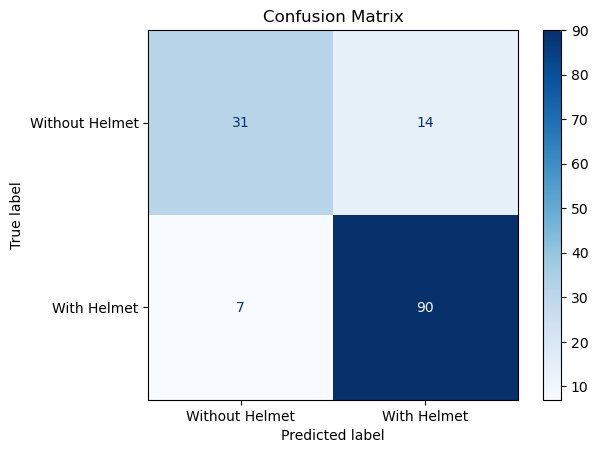

F1 Score: 0.8955


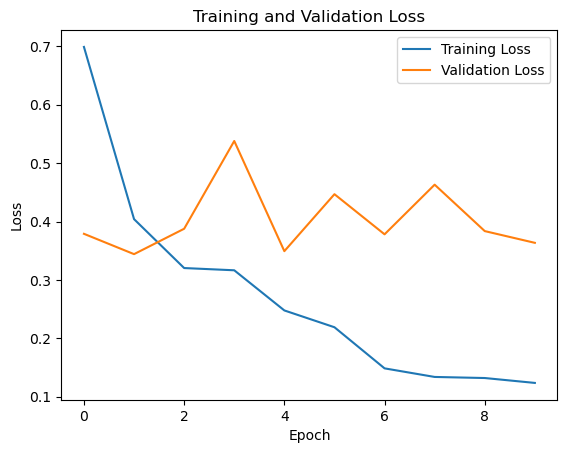

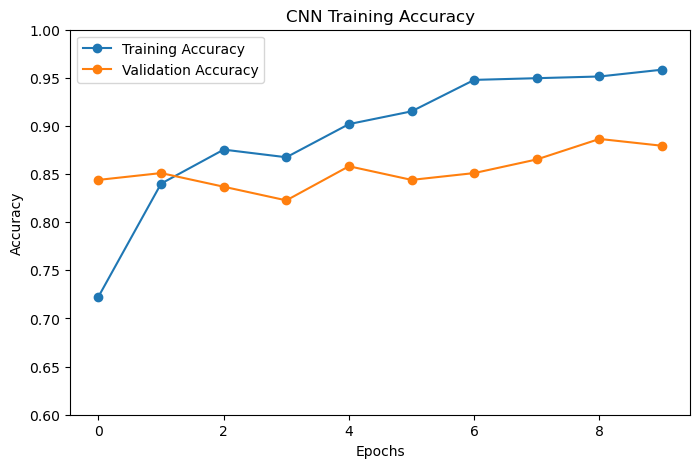

In [98]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=g_epochs, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

In [79]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Epoch 1/10
36/36 [==============================] - 6s 132ms/step - loss: 0.6772 - accuracy: 0.6731 - precision_2: 0.7220 - recall_2: 0.8799 - val_loss: 0.6135 - val_accuracy: 0.8511 - val_precision_2: 0.9341 - val_recall_2: 0.8500
Epoch 2/10
36/36 [==============================] - 5s 130ms/step - loss: 0.5235 - accuracy: 0.7765 - precision_2: 0.8434 - recall_2: 0.8105 - val_loss: 0.3824 - val_accuracy: 0.7872 - val_precision_2: 0.7869 - val_recall_2: 0.9600
Epoch 3/10
36/36 [==============================] - 5s 142ms/step - loss: 0.5626 - accuracy: 0.7376 - precision_2: 0.8433 - recall_2: 0.7379 - val_loss: 0.4849 - val_accuracy: 0.7589 - val_precision_2: 0.9714 - val_recall_2: 0.6800
Epoch 4/10
36/36 [==============================] - 5s 134ms/step - loss: 0.4219 - accuracy: 0.8021 - precision_2: 0.8916 - recall_2: 0.7957 - val_loss: 0.3398 - val_accuracy: 0.8652 - val_precision_2: 0.9551 - val_recall_2: 0.8500
Epoch 5/10
36/36 [==============================] - 5s 129ms/step - loss

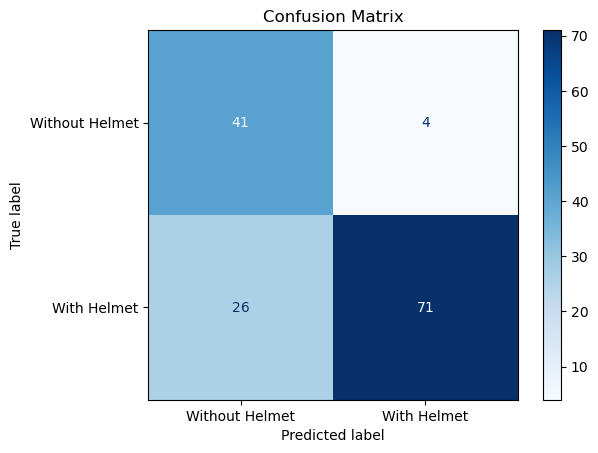

F1 Score: 0.8256


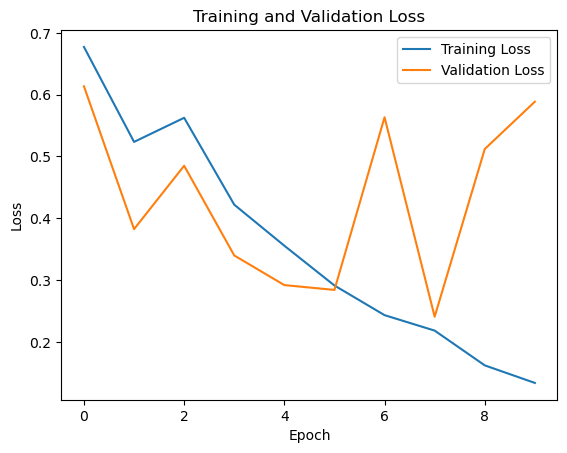

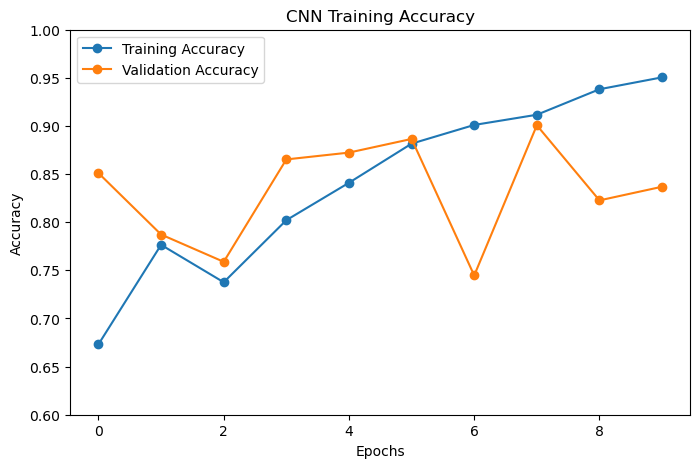

In [80]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=g_epochs,class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### L2 regularizer

Epoch 1/10
36/36 [==============================] - 5s 126ms/step - loss: 0.7419 - accuracy: 0.6935 - precision_2: 0.8110 - recall_2: 0.7039 - val_loss: 0.7106 - val_accuracy: 0.6879 - val_precision_2: 0.9667 - val_recall_2: 0.5800
Epoch 2/10
36/36 [==============================] - 4s 117ms/step - loss: 0.5697 - accuracy: 0.7889 - precision_2: 0.8855 - recall_2: 0.7796 - val_loss: 0.6575 - val_accuracy: 0.6879 - val_precision_2: 0.9375 - val_recall_2: 0.6000
Epoch 3/10
36/36 [==============================] - 4s 120ms/step - loss: 0.4894 - accuracy: 0.8313 - precision_2: 0.8967 - recall_2: 0.8401 - val_loss: 0.8607 - val_accuracy: 0.6170 - val_precision_2: 1.0000 - val_recall_2: 0.4600
Epoch 4/10
36/36 [==============================] - 4s 117ms/step - loss: 0.4894 - accuracy: 0.8269 - precision_2: 0.9018 - recall_2: 0.8266 - val_loss: 0.5312 - val_accuracy: 0.8227 - val_precision_2: 0.9412 - val_recall_2: 0.8000
Epoch 5/10
36/36 [==============================] - 4s 115ms/step - loss

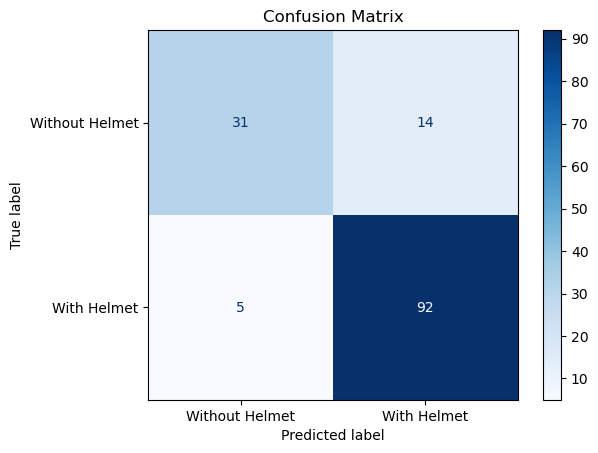

F1 Score: 0.9064


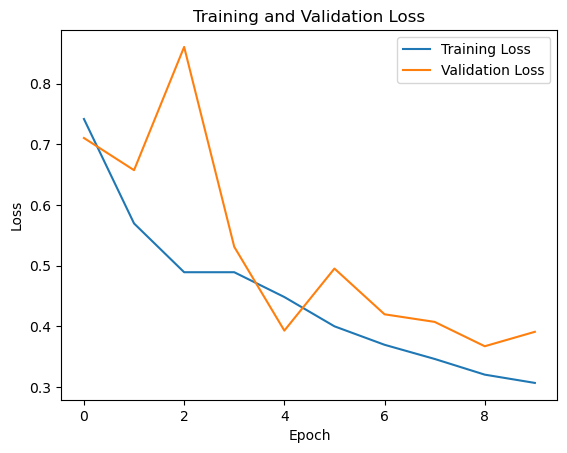

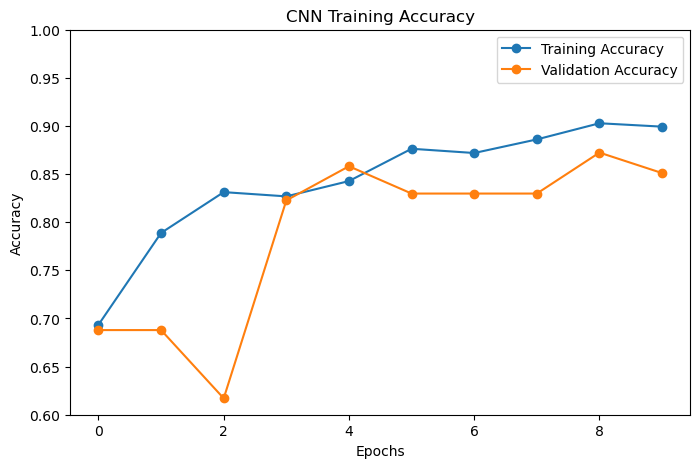

In [113]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=g_epochs, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

Epoch 1/10
36/36 [==============================] - 6s 131ms/step - loss: 1.0193 - accuracy: 0.7120 - precision_2: 0.8043 - recall_2: 0.7622 - val_loss: 0.7289 - val_accuracy: 0.8014 - val_precision_2: 0.9186 - val_recall_2: 0.7900
Epoch 2/10
36/36 [==============================] - 4s 125ms/step - loss: 0.6753 - accuracy: 0.8171 - precision_2: 0.9001 - recall_2: 0.8118 - val_loss: 0.5439 - val_accuracy: 0.8298 - val_precision_2: 0.8878 - val_recall_2: 0.8700
Epoch 3/10
36/36 [==============================] - 5s 133ms/step - loss: 0.5595 - accuracy: 0.8392 - precision_2: 0.9003 - recall_2: 0.8495 - val_loss: 0.5441 - val_accuracy: 0.8794 - val_precision_2: 0.9663 - val_recall_2: 0.8600
Epoch 4/10
36/36 [==============================] - 5s 127ms/step - loss: 0.5558 - accuracy: 0.8216 - precision_2: 0.8928 - recall_2: 0.8280 - val_loss: 0.4808 - val_accuracy: 0.8511 - val_precision_2: 0.9341 - val_recall_2: 0.8500
Epoch 5/10
36/36 [==============================] - 5s 128ms/step - loss

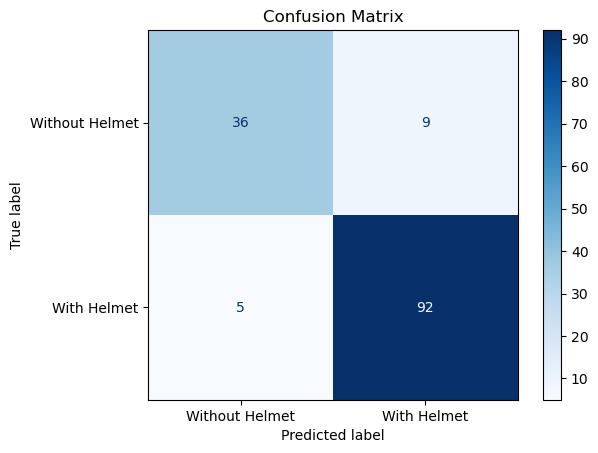

F1 Score: 0.9293


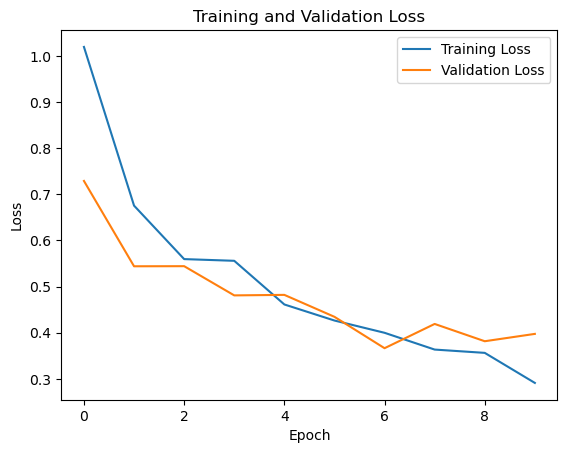

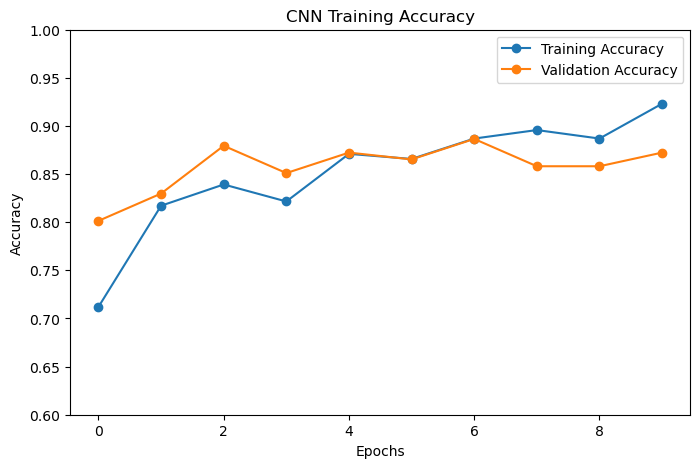

In [81]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=g_epochs, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### Learning rate

Epoch 1/10
36/36 [==============================] - 6s 141ms/step - loss: 1.1161 - accuracy: 0.7005 - precision_2: 0.8220 - recall_2: 0.7301 - val_loss: 0.9633 - val_accuracy: 0.7376 - val_precision_2: 0.9091 - val_recall_2: 0.7000
Epoch 2/10
36/36 [==============================] - 5s 130ms/step - loss: 0.8582 - accuracy: 0.8171 - precision_2: 0.8908 - recall_2: 0.8226 - val_loss: 0.9294 - val_accuracy: 0.7305 - val_precision_2: 0.9429 - val_recall_2: 0.6600
Epoch 3/10
36/36 [==============================] - 5s 132ms/step - loss: 0.7991 - accuracy: 0.7968 - precision_2: 0.8757 - recall_2: 0.8051 - val_loss: 0.8325 - val_accuracy: 0.7801 - val_precision_2: 0.9600 - val_recall_2: 0.7200
Epoch 4/10
36/36 [==============================] - 5s 125ms/step - loss: 0.6715 - accuracy: 0.8366 - precision_2: 0.9092 - recall_2: 0.8347 - val_loss: 0.5711 - val_accuracy: 0.8865 - val_precision_2: 0.8818 - val_recall_2: 0.9700
Epoch 5/10
36/36 [==============================] - 5s 127ms/step - loss

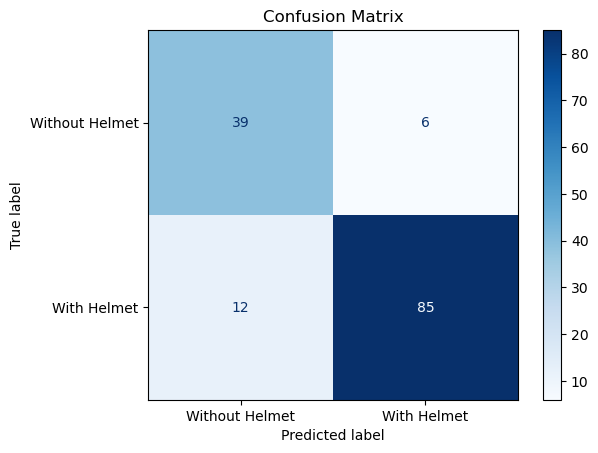

F1 Score: 0.9043


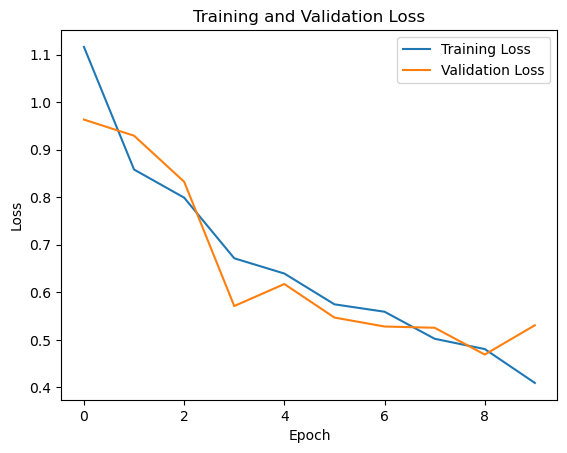

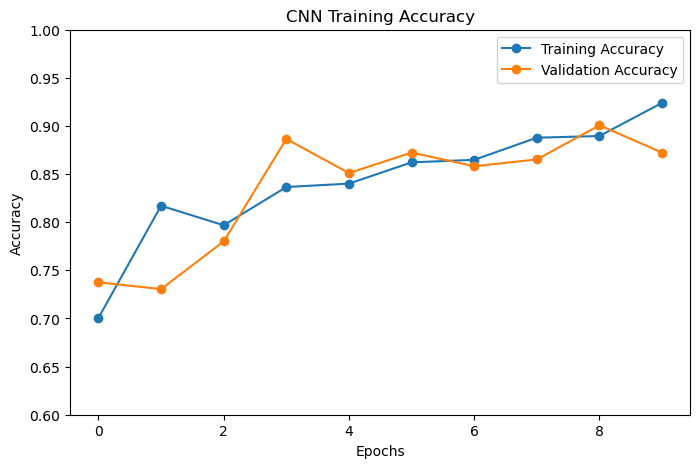

In [99]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=g_epochs, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

Epoch 1/10
36/36 [==============================] - 6s 131ms/step - loss: 0.9497 - accuracy: 0.6793 - precision_2: 0.7544 - recall_2: 0.8109 - val_loss: 0.9457 - val_accuracy: 0.5106 - val_precision_2: 0.9697 - val_recall_2: 0.3200
Epoch 2/10
36/36 [==============================] - 5s 125ms/step - loss: 0.6284 - accuracy: 0.7367 - precision_2: 0.8608 - recall_2: 0.7151 - val_loss: 0.5194 - val_accuracy: 0.7943 - val_precision_2: 0.9383 - val_recall_2: 0.7600
Epoch 3/10
36/36 [==============================] - 5s 127ms/step - loss: 0.5280 - accuracy: 0.7862 - precision_2: 0.8922 - recall_2: 0.7675 - val_loss: 0.4408 - val_accuracy: 0.8794 - val_precision_2: 0.9109 - val_recall_2: 0.9200
Epoch 4/10
36/36 [==============================] - 4s 123ms/step - loss: 0.5272 - accuracy: 0.7747 - precision_2: 0.8644 - recall_2: 0.7796 - val_loss: 0.5073 - val_accuracy: 0.8014 - val_precision_2: 0.9500 - val_recall_2: 0.7600
Epoch 5/10
36/36 [==============================] - 5s 125ms/step - loss

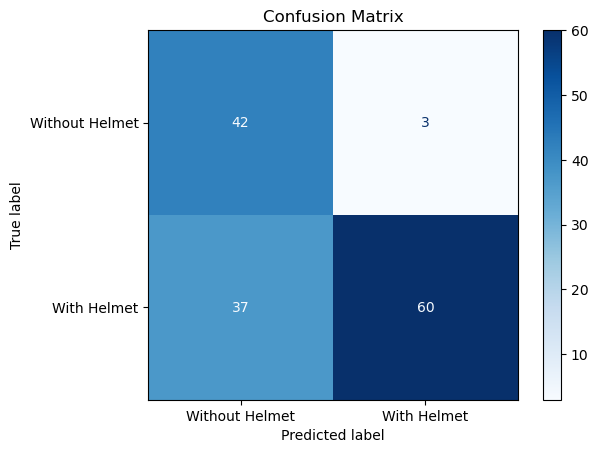

F1 Score: 0.7500


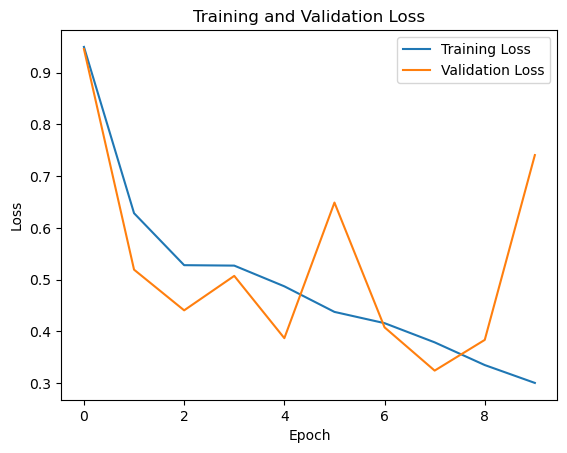

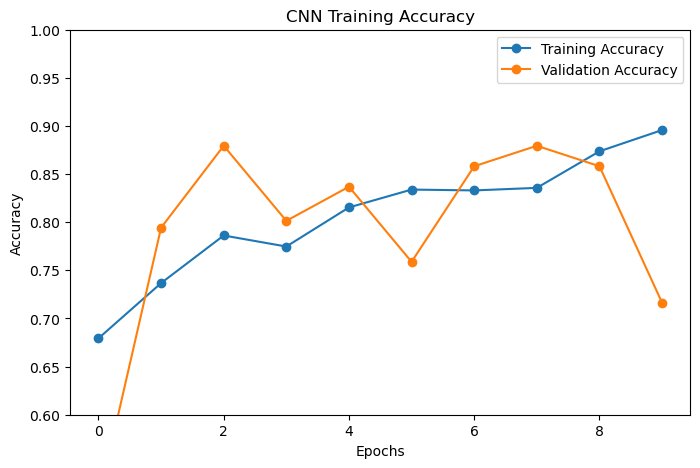

In [100]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=g_epochs, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

## Bayesian Optimization

### CNN

In [32]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_filters_0=16, num_filters_1=16, num_filters_2=16, num_units_0=16, num_units_1=16):
        self.num_filters_0 = num_filters_0
        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.num_units_0 = num_units_0
        self.num_units_1 = num_units_1
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(self.num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(self.num_filters_1, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(self.num_filters_2, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(self.num_units_0, activation='relu'))
        model.add(Dense(self.num_units_1, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_filters_0, self.num_filters_1, self.num_filters_2, self.num_units_0, self.num_units_1)
        self.model.fit(X, y, epochs=10,class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None, verbose=0)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [33]:
hp_space = {
    'num_filters_0': (16, 256),
    'num_filters_1': (16, 256),
    'num_filters_2': (16, 256),
    'num_units_0' : (16, 256),
    'num_units_1' : (16, 256),
}

In [21]:
def val_accuracy_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    val_accuracy = accuracy_score(y, y_pred)
    print("Score: ",val_accuracy)
    return val_accuracy

In [35]:
keras_model_wrapper = KerasClassifierWrapper()

In [36]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space,
    n_iter=50,
    cv=3,
    scoring=val_accuracy_scorer,
    random_state=42,
)

In [37]:
opt.fit(X_train, y_train)

114 191 240 92 177
12/12 [==============================] - 0s 24ms/step
Score:  0.8201058201058201
114 191 240 92 177
12/12 [==============================] - 0s 23ms/step
Score:  0.8620689655172413
114 191 240 92 177
12/12 [==============================] - 0s 23ms/step
Score:  0.8143236074270557
217 228 89 244 223
12/12 [==============================] - 0s 23ms/step
Score:  0.8227513227513228
217 228 89 244 223
12/12 [==============================] - 0s 23ms/step
Score:  0.8222811671087533
217 228 89 244 223
12/12 [==============================] - 0s 23ms/step
Score:  0.7771883289124668
123 236 41 120 61
12/12 [==============================] - 0s 23ms/step
Score:  0.843915343915344
123 236 41 120 61
12/12 [==============================] - 0s 24ms/step
Score:  0.830238726790451
123 236 41 120 61
12/12 [==============================] - 0s 23ms/step
Score:  0.8461538461538461
211 57 160 209 142
12/12 [==============================] - 0s 23ms/step
Score:  0.8174603174603174
211 5

BayesSearchCV(cv=3, estimator=KerasClassifierWrapper(), random_state=42,
              scoring=<function val_accuracy_scorer at 0x00000247693A0A40>,
              search_spaces={'num_filters_0': (16, 256),
                             'num_filters_1': (16, 256),
                             'num_filters_2': (16, 256),
                             'num_units_0': (16, 256),
                             'num_units_1': (16, 256)})

<Figure size 640x480 with 0 Axes>

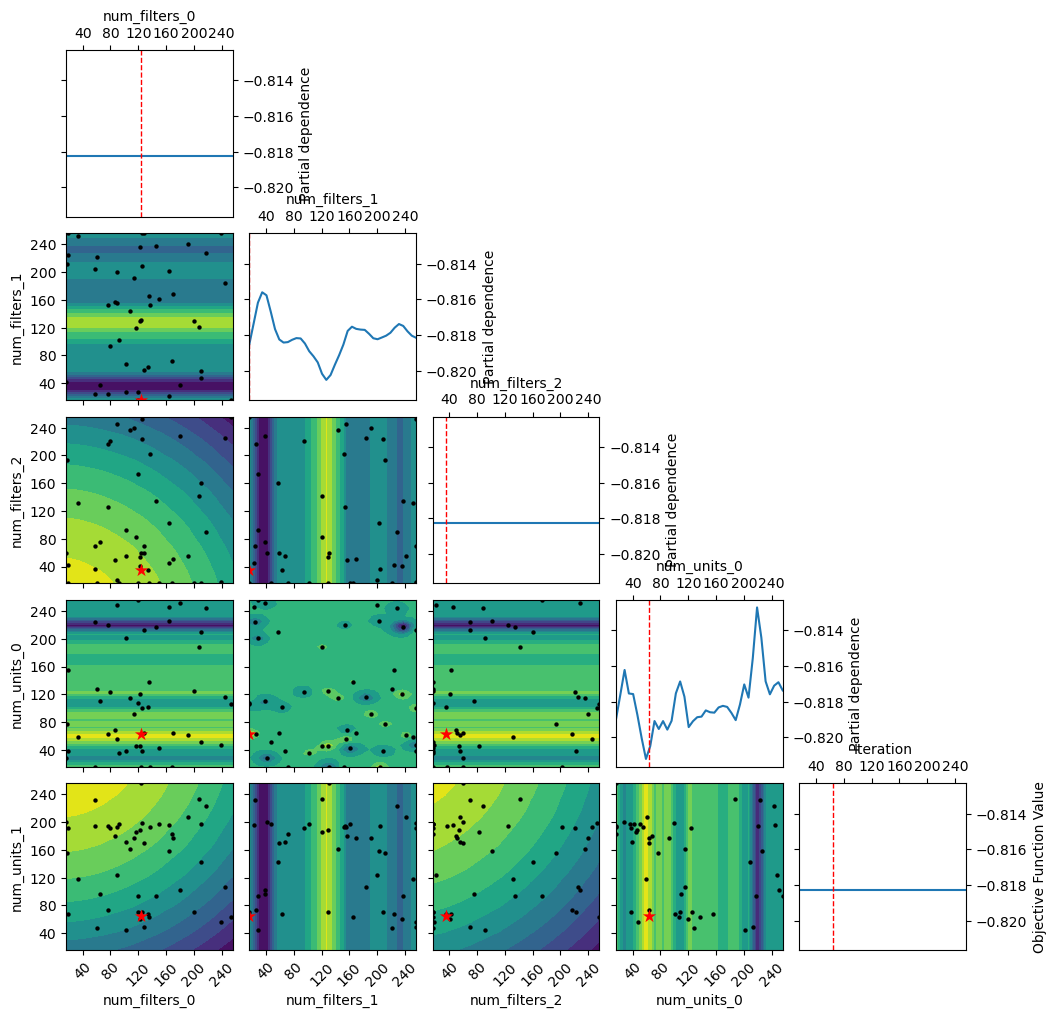

In [38]:
plt.figure()
plot_objective(opt.optimizer_results_[0])
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.show()

In [39]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('num_filters_0', 124), ('num_filters_1', 16), ('num_filters_2', 35), ('num_units_0', 63), ('num_units_1', 65)])


In [116]:
def opt_cnn_model(num_filters_0, num_filters_1, num_filters_2, num_units_0, num_units_1):
    model = Sequential()
    model.add(Conv2D(num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_1, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(num_units_0, activation='relu'))
    model.add(Dense(num_units_1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'] + additional_metrics)
    return model

Epoch 1/10
36/36 [==============================] - 144s 4s/step - loss: 2.3017 - accuracy: 0.6025 - precision_2: 0.7493 - recall_2: 0.6647 - val_loss: 1.5649 - val_accuracy: 0.5390 - val_precision_2: 1.0000 - val_recall_2: 0.3500
Epoch 2/10
36/36 [==============================] - 148s 4s/step - loss: 0.9961 - accuracy: 0.7615 - precision_2: 0.8613 - recall_2: 0.7594 - val_loss: 0.7774 - val_accuracy: 0.8085 - val_precision_2: 0.9101 - val_recall_2: 0.8100
Epoch 3/10
36/36 [==============================] - 154s 4s/step - loss: 0.7772 - accuracy: 0.7686 - precision_2: 0.8555 - recall_2: 0.7796 - val_loss: 0.9333 - val_accuracy: 0.6596 - val_precision_2: 0.9815 - val_recall_2: 0.5300
Epoch 4/10
36/36 [==============================] - 141s 4s/step - loss: 0.6489 - accuracy: 0.7924 - precision_2: 0.8683 - recall_2: 0.8065 - val_loss: 0.8725 - val_accuracy: 0.5461 - val_precision_2: 0.9286 - val_recall_2: 0.3900
Epoch 5/10
36/36 [==============================] - 139s 4s/step - loss: 0.5

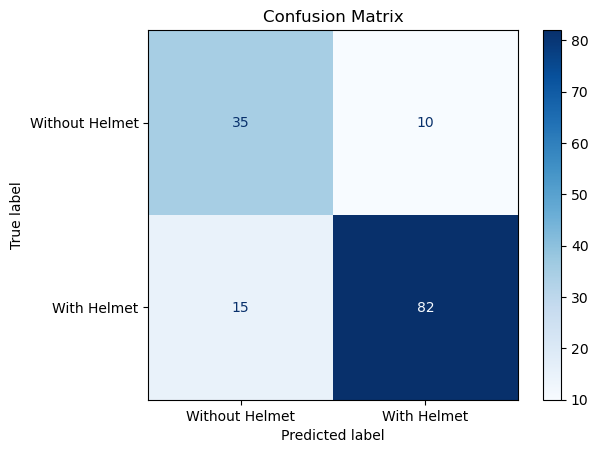

F1 Score: 0.8677


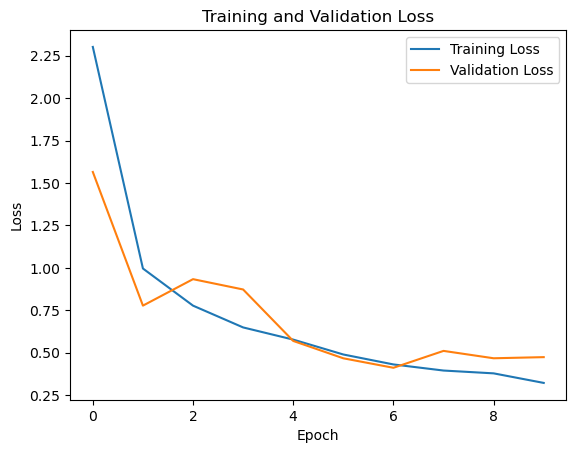

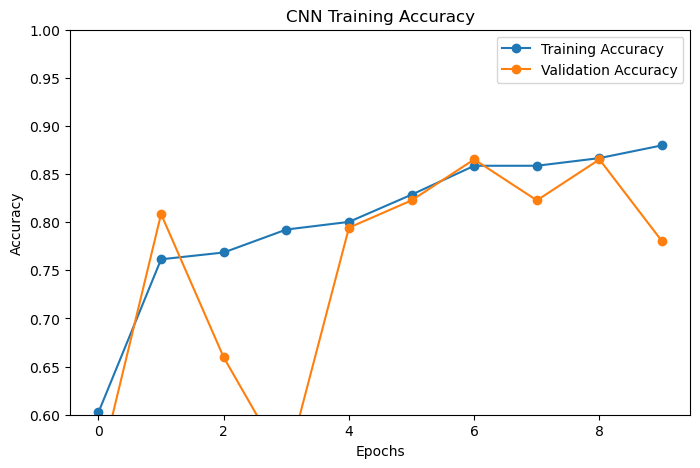

In [117]:
model = opt_cnn_model(114, 191, 240, 92, 177)
history = model.fit(X_train, y_train, epochs=10,class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)
print_metrics(model)
plot_cost_function(history)

In [43]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, num_conv_layers=1, num_filters_0=16, num_filters_1=16, num_dense_layers=1, num_units_0=16, l2_reg=0.0, dropout=0.0):
        self.learning_rate = learning_rate
        self.num_conv_layers = num_conv_layers
        self.num_filters_0 = num_filters_0
        self.num_filters_1 = num_filters_1
        self.num_dense_layers = num_dense_layers
        self.num_units_0 = num_units_0
        self.l2_reg = l2_reg
        self.dropout = dropout
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(self.num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        for _ in range(self.num_conv_layers):
            model.add(Conv2D(self.num_filters_1, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(self.l2_reg)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(self.dropout))
        model.add(Flatten())
        for _ in range(self.num_dense_layers):
            model.add(Dense(self.num_units_0, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=self.learning_rate), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.learning_rate, self.num_conv_layers, self.num_filters_0, self.num_filters_1, self.num_dense_layers, self.num_units_0, self.l2_reg, self.dropout)
        self.model.fit(X, y, epochs=10,class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None, verbose=0)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [44]:
hp_space = {
    'learning_rate': (0.00001, 0.1),
    'num_conv_layers': (1, 5),
    'num_filters_0': (16, 256),
    'num_filters_1': (16, 256),
    'num_dense_layers': (1,3),
    'num_units_0': (16, 256),
    'l2_reg': (0.0, 0.3),
    'dropout': (0.0, 0.5)
}

In [45]:
keras_model_wrapper = KerasClassifierWrapper()

In [46]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space,
    n_iter=150,
    cv=3,
    scoring=val_accuracy_scorer,
    random_state=42,
)
opt.fit(X_train, y_train)

0.09328747120479491 2 115 100 2 193 0.2183177229531975 0.20505197942665693
12/12 [==============================] - 0s 22ms/step
Score:  0.8597883597883598
0.09328747120479491 2 115 100 2 193 0.2183177229531975 0.20505197942665693
12/12 [==============================] - 0s 22ms/step
Score:  0.8381962864721485
0.09328747120479491 2 115 100 2 193 0.2183177229531975 0.20505197942665693
12/12 [==============================] - 0s 23ms/step
Score:  0.8275862068965517
0.03034797688731866 5 31 49 3 101 0.26499458321425867 0.4186941777766422
12/12 [==============================] - 0s 22ms/step
Score:  0.8148148148148148
0.03034797688731866 5 31 49 3 101 0.26499458321425867 0.4186941777766422
12/12 [==============================] - 0s 22ms/step
Score:  0.8010610079575596
0.03034797688731866 5 31 49 3 101 0.26499458321425867 0.4186941777766422
12/12 [==============================] - 0s 22ms/step
Score:  0.843501326259947
0.010494867263684832 3 125 53 1 196 0.27561675650081313 0.2224162561505

BayesSearchCV(cv=3, estimator=KerasClassifierWrapper(), n_iter=150,
              random_state=42,
              scoring=<function val_accuracy_scorer at 0x00000247693A0A40>,
              search_spaces={'dropout': (0.0, 0.5), 'l2_reg': (0.0, 0.3),
                             'learning_rate': (1e-05, 0.1),
                             'num_conv_layers': (1, 5),
                             'num_dense_layers': (1, 3),
                             'num_filters_0': (16, 256),
                             'num_filters_1': (16, 256),
                             'num_units_0': (16, 256)})

<Figure size 640x480 with 0 Axes>

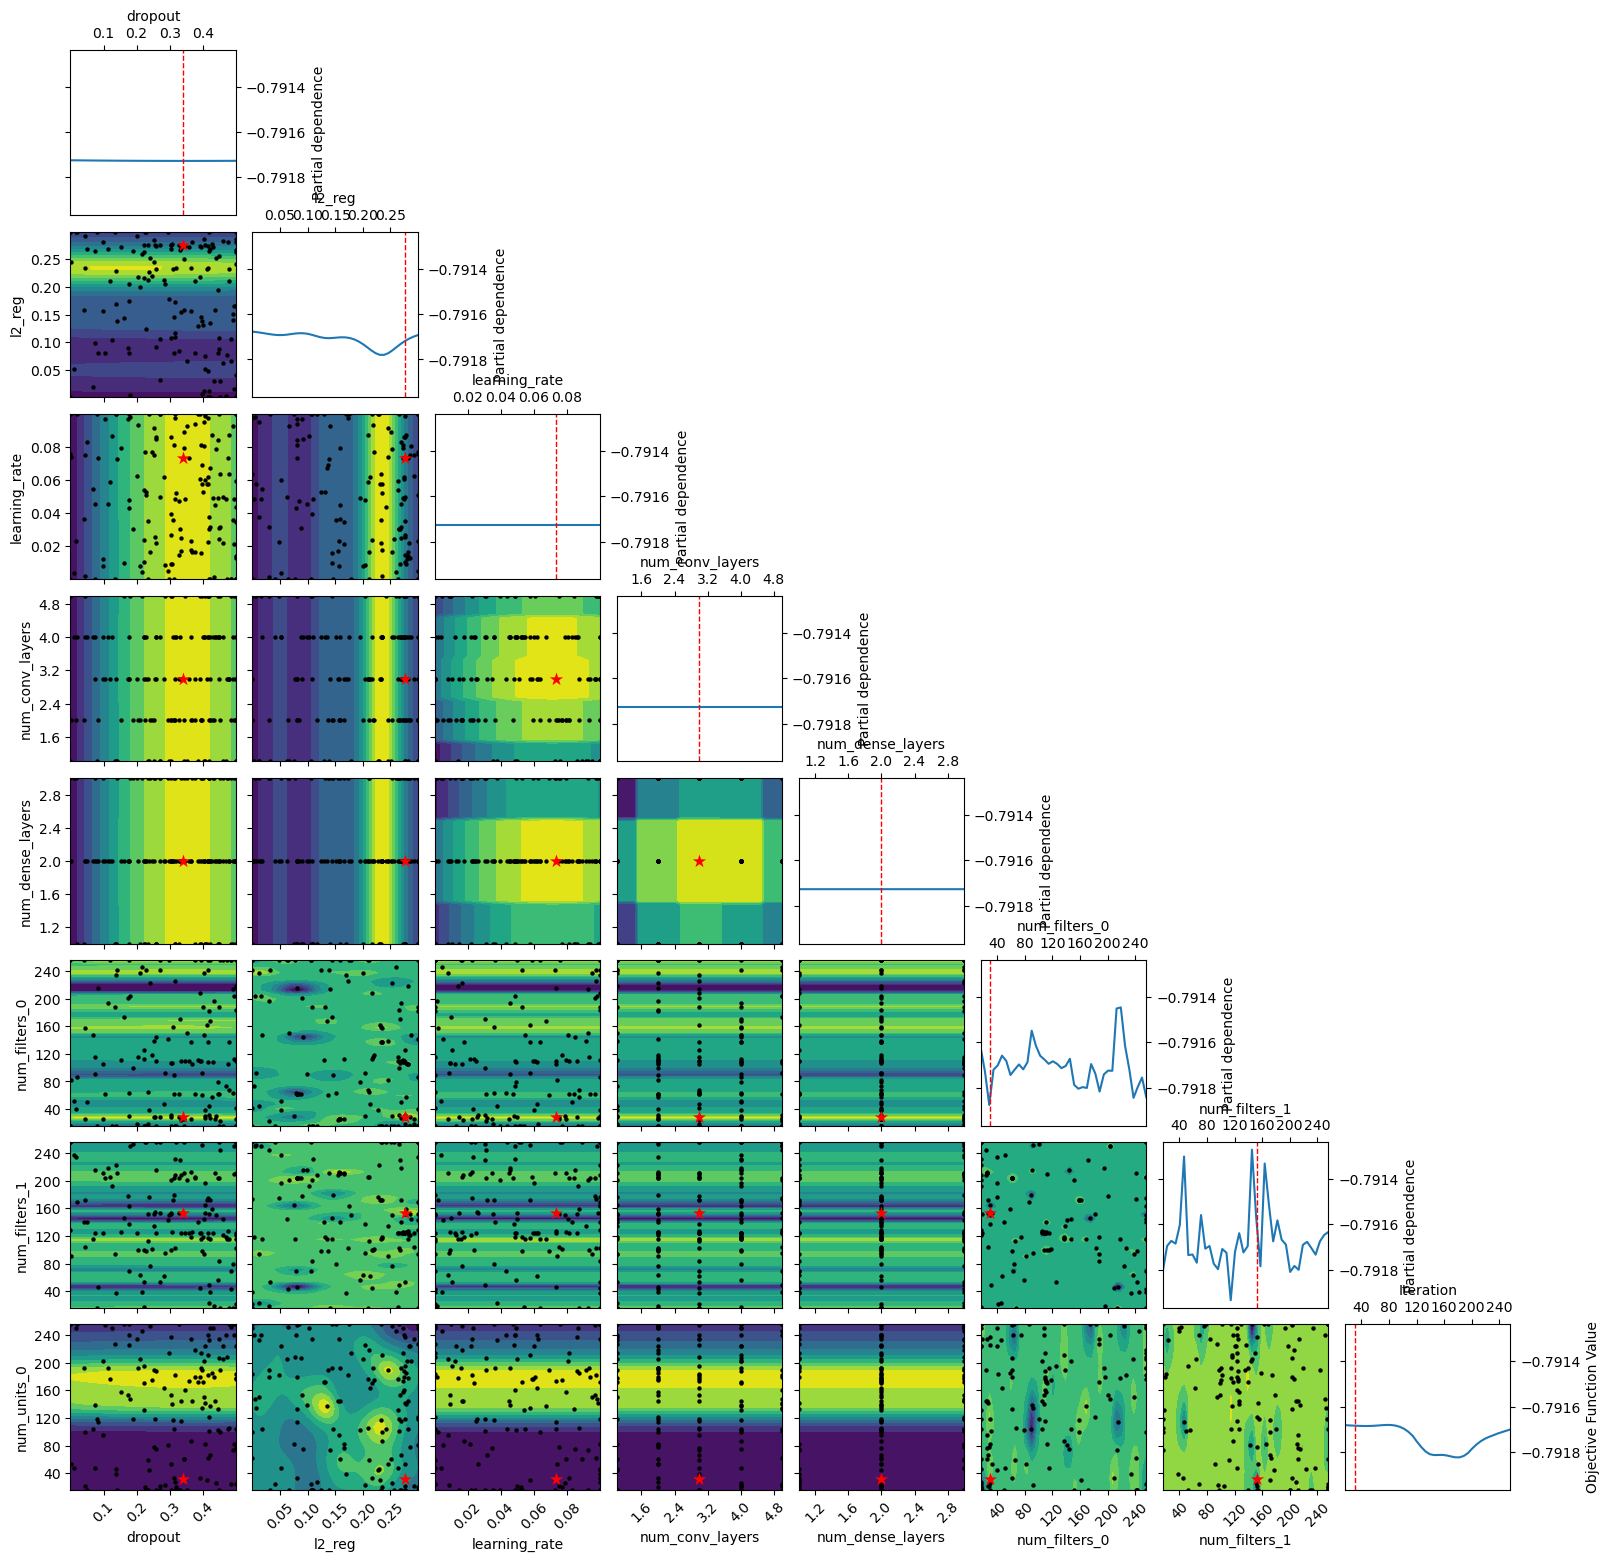

In [47]:
plt.figure()
plot_objective(opt.optimizer_results_[0])
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.show()

In [48]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('dropout', 0.34009735662630886), ('l2_reg', 0.27610129222292923), ('learning_rate', 0.07332129512512003), ('num_conv_layers', 3), ('num_dense_layers', 2), ('num_filters_0', 29), ('num_filters_1', 153), ('num_units_0', 31)])


In [19]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_conv_layers=1, num_filters_0=16, num_filters_1=16, num_dense_layers=1, num_units_0=16, l2_reg=0.0):
        self.num_conv_layers = num_conv_layers
        self.num_filters_0 = num_filters_0
        self.num_filters_1 = num_filters_1
        self.num_dense_layers = num_dense_layers
        self.num_units_0 = num_units_0
        self.l2_reg = l2_reg
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(self.num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        for _ in range(self.num_conv_layers):
            model.add(Conv2D(self.num_filters_1, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(self.l2_reg)))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        for _ in range(self.num_dense_layers):
            model.add(Dense(self.num_units_0, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_conv_layers, self.num_filters_0, self.num_filters_1, self.num_dense_layers, self.num_units_0, self.l2_reg)
        self.model.fit(X, y, epochs=10,class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None, verbose=0)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

hp_space = {
    'num_conv_layers': (1, 5),
    'num_filters_0': (16, 256),
    'num_filters_1': (16, 256),
    'num_dense_layers': (1,3),
    'num_units_0': (16, 256),
    'l2_reg': (0.0, 0.3),
}

In [22]:
keras_model_wrapper = KerasClassifierWrapper()
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space,
    n_iter=150,
    cv=3,
    scoring=val_accuracy_scorer,
    random_state=42,
)
opt.fit(X_train, y_train)

4 92 177 3 115 0.12303118765599415


12/12 [==============================] - 0s 22ms/step
Score:  0.8492063492063492
4 92 177 3 115 0.12303118765599415
12/12 [==============================] - 0s 27ms/step
Score:  0.8090185676392573
4 92 177 3 115 0.12303118765599415
12/12 [==============================] - 0s 24ms/step
Score:  0.7400530503978779
5 244 223 2 31 0.25121650666598533
12/12 [==============================] - 0s 24ms/step
Score:  0.8624338624338624
5 244 223 2 31 0.25121650666598533
12/12 [==============================] - 0s 22ms/step
Score:  0.7453580901856764
5 244 223 2 31 0.25121650666598533
12/12 [==============================] - 0s 23ms/step
Score:  0.7692307692307693
5 120 61 1 125 0.13344975369034554
12/12 [==============================] - 0s 22ms/step
Score:  0.8492063492063492
5 120 61 1 125 0.13344975369034554
12/12 [==============================] - 0s 23ms/step
Score:  0.8328912466843501
5 120 61 1 125 0.13344975369034554
12/12 [============================

BayesSearchCV(cv=3, estimator=KerasClassifierWrapper(), n_iter=150,
              random_state=42,
              scoring=<function val_accuracy_scorer at 0x0000019DD0ECA520>,
              search_spaces={'l2_reg': (0.0, 0.3), 'num_conv_layers': (1, 5),
                             'num_dense_layers': (1, 3),
                             'num_filters_0': (16, 256),
                             'num_filters_1': (16, 256),
                             'num_units_0': (16, 256)})

In [23]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('l2_reg', 0.19548983724418573), ('num_conv_layers', 1), ('num_dense_layers', 2), ('num_filters_0', 144), ('num_filters_1', 20), ('num_units_0', 16)])


<Figure size 640x480 with 0 Axes>

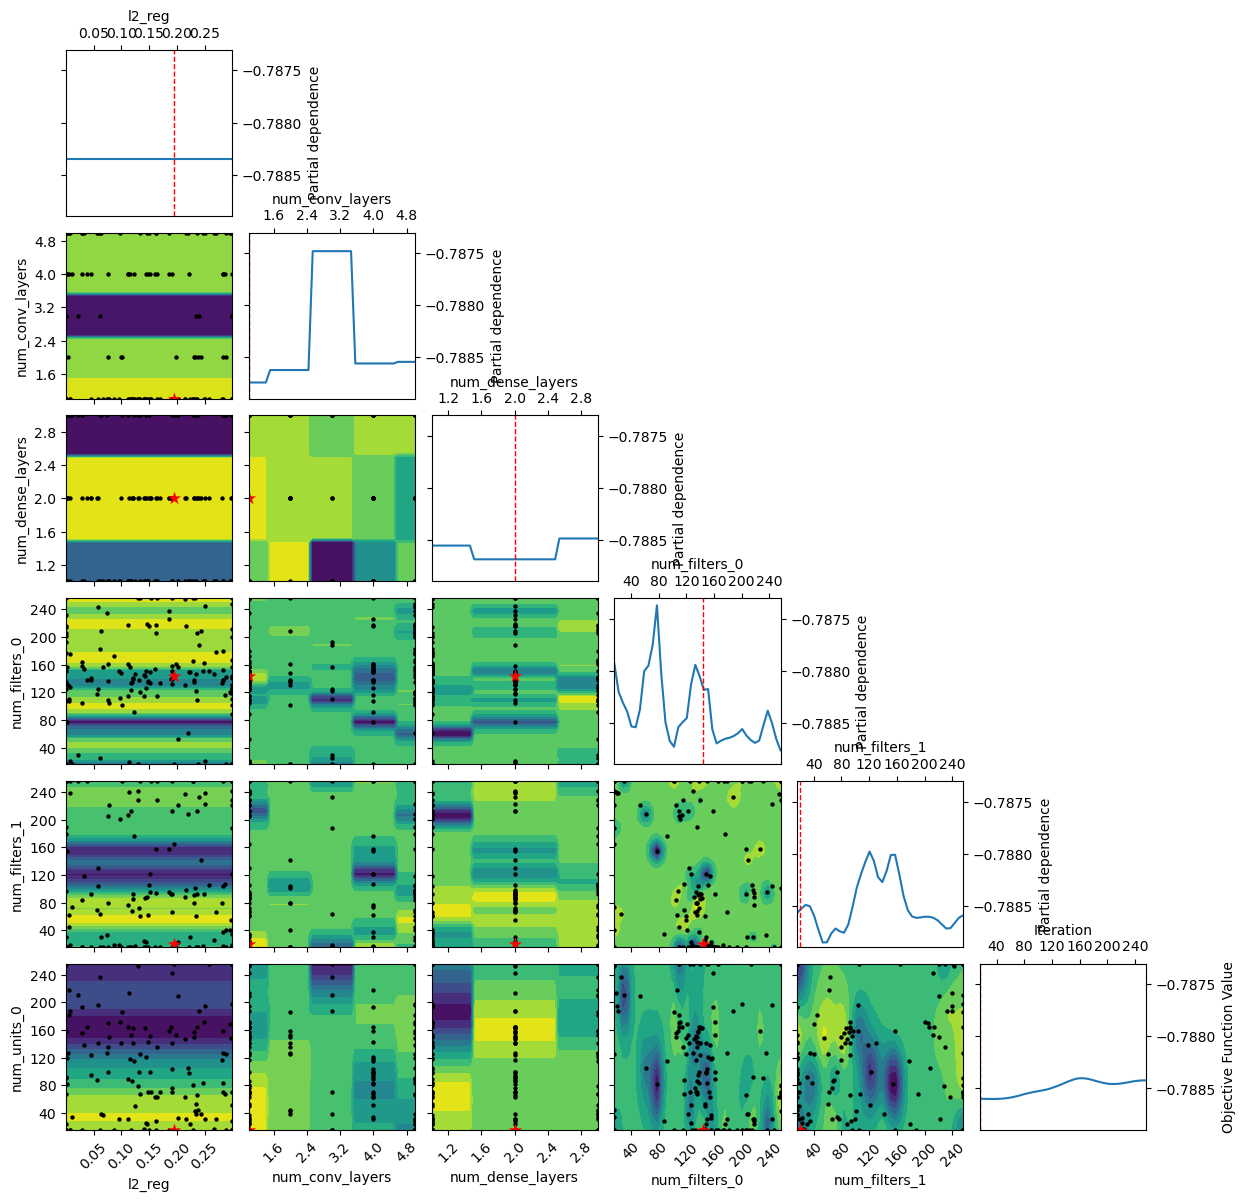

In [24]:
plt.figure()
plot_objective(opt.optimizer_results_[0])
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.show()

Epoch 1/10
36/36 [==============================] - 36s 985ms/step - loss: 4.1476 - accuracy: 0.5000 - precision: 0.6654 - recall: 0.4812 - val_loss: 1.8337 - val_accuracy: 0.2908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
36/36 [==============================] - 33s 926ms/step - loss: 1.2035 - accuracy: 0.4876 - precision: 0.7216 - recall: 0.3589 - val_loss: 0.8587 - val_accuracy: 0.4113 - val_precision: 0.8148 - val_recall: 0.2200
Epoch 3/10
36/36 [==============================] - 33s 930ms/step - loss: 0.7257 - accuracy: 0.6970 - precision: 0.7953 - recall: 0.7258 - val_loss: 0.6150 - val_accuracy: 0.7518 - val_precision: 0.8736 - val_recall: 0.7600
Epoch 4/10
36/36 [==============================] - 33s 921ms/step - loss: 0.6343 - accuracy: 0.7306 - precision: 0.7995 - recall: 0.7876 - val_loss: 0.6432 - val_accuracy: 0.6879 - val_precision: 0.9000 - val_recall: 0.6300
Epoch 5/10
36/36 [==============================] - 33s 926ms/step - loss: 0.6075 - accuracy

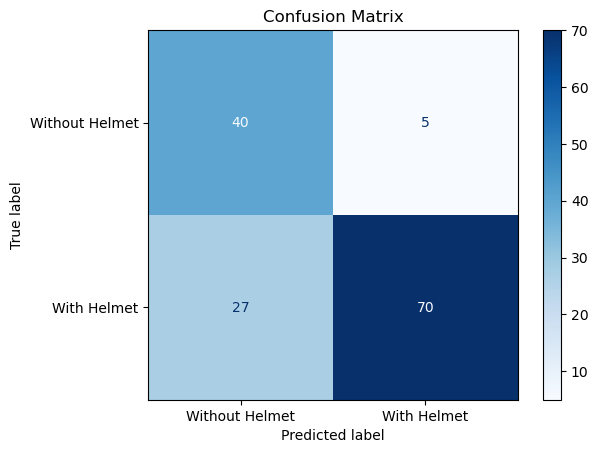

F1 Score: 0.8140


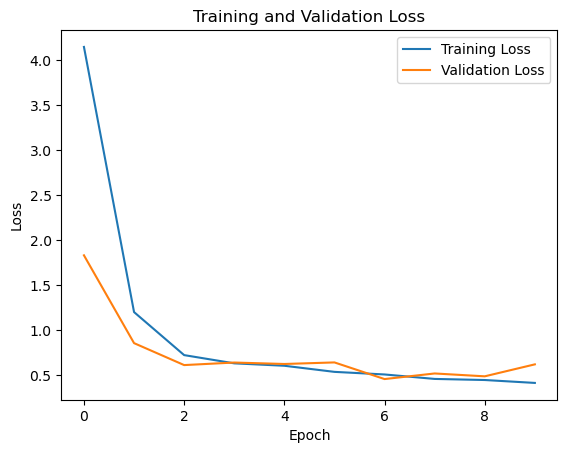

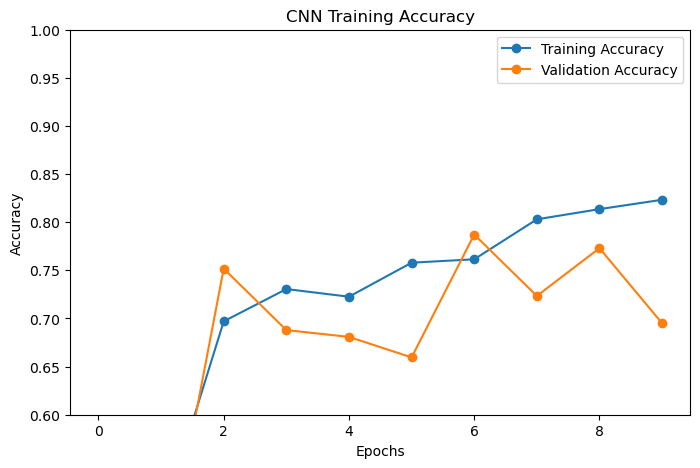

In [25]:
model = Sequential()
model.add(Conv2D(144, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu', kernel_regularizer=l2(0.19548983724418573)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

Epoch 1/10
36/36 [==============================] - 35s 922ms/step - loss: 4369.7720 - accuracy: 0.5512 - precision: 0.6596 - recall: 0.7075 - val_loss: 3974.1836 - val_accuracy: 0.7092 - val_precision: 0.7092 - val_recall: 1.0000
Epoch 2/10
36/36 [==============================] - 32s 880ms/step - loss: 2446.8240 - accuracy: 0.5989 - precision: 0.6562 - recall: 0.8185 - val_loss: 1304.2291 - val_accuracy: 0.2908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
36/36 [==============================] - 32s 878ms/step - loss: 848.3909 - accuracy: 0.4488 - precision: 0.6648 - recall: 0.3253 - val_loss: 513.6956 - val_accuracy: 0.7092 - val_precision: 0.7092 - val_recall: 1.0000
Epoch 4/10
36/36 [==============================] - 32s 883ms/step - loss: 368.5708 - accuracy: 0.5724 - precision: 0.6562 - recall: 0.7339 - val_loss: 255.0397 - val_accuracy: 0.2908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
36/36 [==============================] - 32s 881ms/st

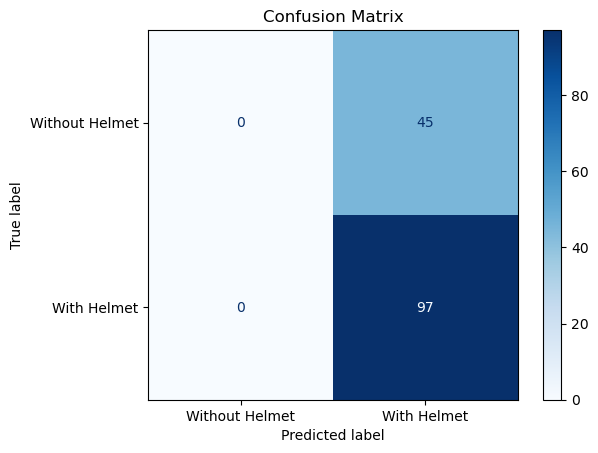

F1 Score: 0.8117


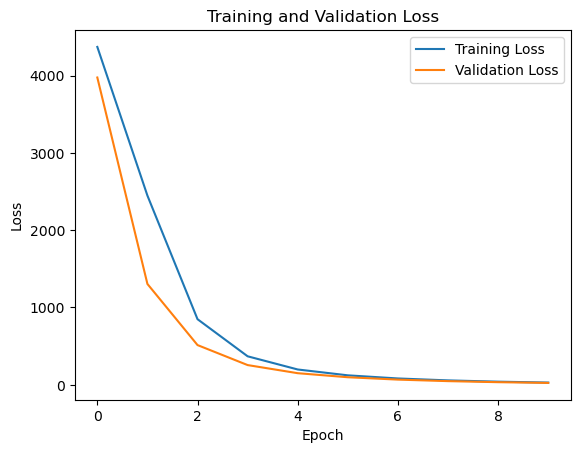

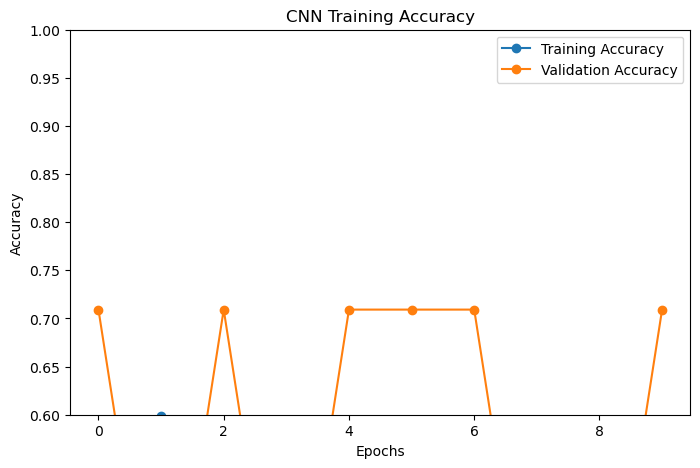

In [50]:
model = Sequential()
model.add(Conv2D(29, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(153, (3, 3), activation='relu', kernel_regularizer=l2(0.27610129222292923)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.34009735662630886))
model.add(Conv2D(153, (3, 3), activation='relu', kernel_regularizer=l2(0.27610129222292923)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.34009735662630886))
model.add(Conv2D(153, (3, 3), activation='relu', kernel_regularizer=l2(0.27610129222292923)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.34009735662630886))
model.add(Flatten())
model.add(Dense(31, activation='relu'))
model.add(Dense(31, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.07332129512512003), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, class_weight=class_weight_dict, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### MLP

In [16]:
class KerasClassifierWrapper_mlp(BaseEstimator, ClassifierMixin):
    def __init__(self, num_units_0=128, num_units_1=256, num_units_2=256):
        self.num_units_0 = num_units_0
        self.num_units_1 = num_units_1
        self.num_units_2 = num_units_2
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(target_size[0], target_size[1], 3)))  # Flatten the images
        model.add(Dense(self.num_units_0, activation='relu'))  
        model.add(Dense(self.num_units_1, activation='relu'))
        model.add(Dense(self.num_units_2, activation='relu'))   
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_units_0,self.num_units_1,self.num_units_2)
        self.model.fit(X, y, epochs=10, validation_data=(X_val, y_val), callbacks=None)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [17]:
def val_accuracy_scorer_mlp(estimator, X, y):
    y_pred = estimator.predict(X)
    val_accuracy = accuracy_score(y, y_pred)
    print("Score: ",val_accuracy)
    return val_accuracy

In [18]:
hp_space_mlp= {
    'num_units_0' : (16, 128),
    'num_units_1' : (16, 128),
    'num_units_2' : (16, 128),
}

In [19]:
keras_model_wrapper = KerasClassifierWrapper_mlp()

In [21]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space_mlp,
    n_iter=10,
    cv=3,
    scoring=val_accuracy_scorer_mlp,
    random_state=42,
)

In [22]:
opt.fit(X_train, y_train)

62 98 120
Epoch 1/10


20/20 [==============================] - 4s 137ms/step - loss: 2.4230 - accuracy: 0.6059 - val_loss: 0.4241 - val_accuracy: 0.8158
Epoch 2/10
20/20 [==============================] - 3s 129ms/step - loss: 0.7314 - accuracy: 0.7143 - val_loss: 0.4283 - val_accuracy: 0.8333
Epoch 3/10
20/20 [==============================] - 3s 131ms/step - loss: 0.5117 - accuracy: 0.7767 - val_loss: 2.4402 - val_accuracy: 0.2982
Epoch 4/10
20/20 [==============================] - 3s 129ms/step - loss: 1.1535 - accuracy: 0.6486 - val_loss: 0.4283 - val_accuracy: 0.8509
Epoch 5/10
20/20 [==============================] - 3s 128ms/step - loss: 0.6006 - accuracy: 0.7537 - val_loss: 0.5194 - val_accuracy: 0.8070
Epoch 6/10
20/20 [==============================] - 3s 128ms/step - loss: 0.4855 - accuracy: 0.7750 - val_loss: 0.3971 - val_accuracy: 0.8509
Epoch 7/10
20/20 [==============================] - 3s 128ms/step - loss: 0.5832 - accuracy: 0.7274 - val_loss: 0.5392 - val_accuracy: 0

BayesSearchCV(cv=3, estimator=KerasClassifierWrapper_mlp(), n_iter=10,
              random_state=42,
              scoring=<function val_accuracy_scorer_mlp at 0x0000012A38527100>,
              search_spaces={'num_units_0': (16, 128), 'num_units_1': (16, 128),
                             'num_units_2': (16, 128)})

In [23]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('num_units_0', 62), ('num_units_1', 98), ('num_units_2', 120)])


In [24]:
def opt_mpl_model(learning_rate,num_units_0, num_units_1,num_units_2):
    model = Sequential()
    model.add(Flatten(input_shape=(target_size[0], target_size[1], 3)))  # Flatten the images
        # Add Dense layers
    model.add(Dense(num_units_0, activation='relu'))  
    model.add(Dense(num_units_1, activation='relu'))
    model.add(Dense(num_units_2, activation='relu'))   
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'] + additional_metrics)
    return model

In [25]:
def plot_cost_function_mlp(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP Training Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

Epoch 1/10
29/29 [==============================] - 3s 78ms/step - loss: 2.0220 - accuracy: 0.6302 - precision: 0.7404 - recall: 0.7241 - val_loss: 0.4600 - val_accuracy: 0.8246 - val_precision: 0.8837 - val_recall: 0.8837
Epoch 2/10
29/29 [==============================] - 2s 69ms/step - loss: 0.6024 - accuracy: 0.7593 - precision: 0.8065 - recall: 0.8621 - val_loss: 0.4331 - val_accuracy: 0.8509 - val_precision: 0.8632 - val_recall: 0.9535
Epoch 3/10
29/29 [==============================] - 2s 70ms/step - loss: 0.5987 - accuracy: 0.7604 - precision: 0.8122 - recall: 0.8542 - val_loss: 0.4389 - val_accuracy: 0.8772 - val_precision: 0.8913 - val_recall: 0.9535
Epoch 4/10
29/29 [==============================] - 2s 70ms/step - loss: 0.6382 - accuracy: 0.7516 - precision: 0.8053 - recall: 0.8495 - val_loss: 0.4616 - val_accuracy: 0.8158 - val_precision: 0.8155 - val_recall: 0.9767
Epoch 5/10
29/29 [==============================] - 2s 70ms/step - loss: 0.4389 - accuracy: 0.8074 - precisi

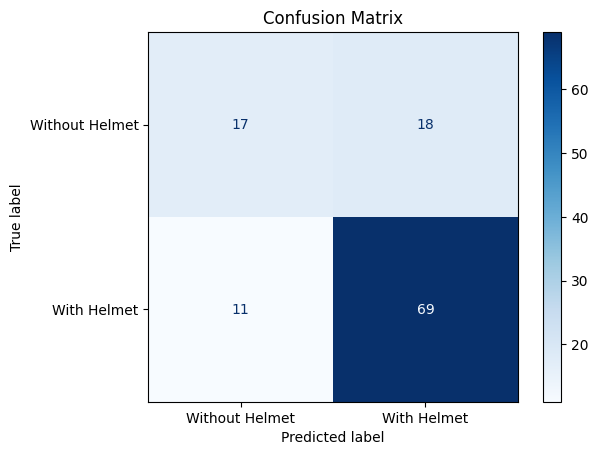

F1 Score: 0.8263


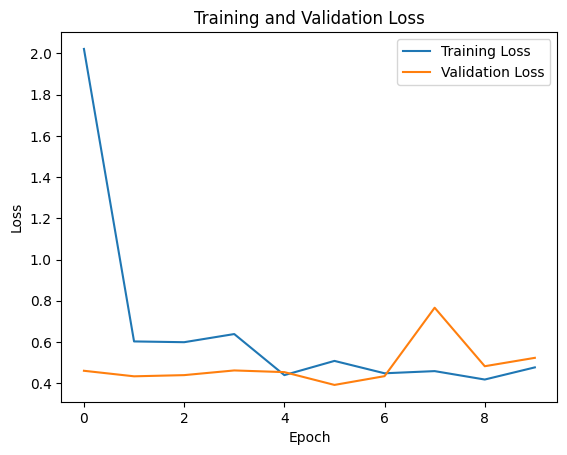

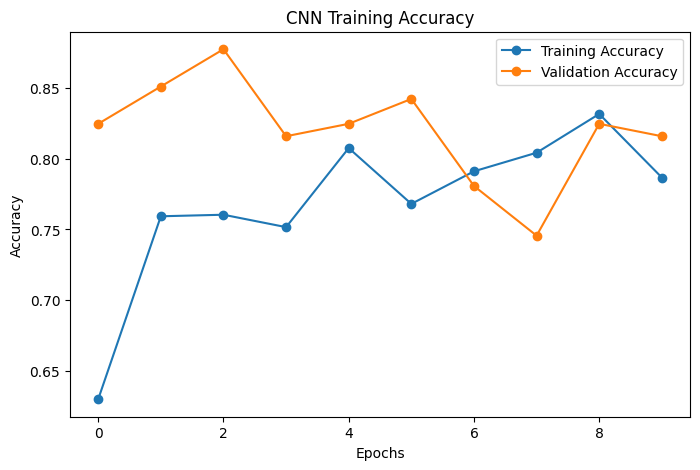

In [26]:
model = opt_mpl_model(0.001,62,98,120)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)
print_metrics(model)
plot_cost_function(history)